<a href="https://colab.research.google.com/github/zohaibkhanzohaibi/NIS-CCP/blob/main/freq_analysis_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🚀 Starting Cipher Attack Performance Evaluation...
Starting experiment with 160 total trials...

--- Config: Length=100, Key_Len=4 (10 trials) ---
  Trial 1/10 complete: Found=True (Rank=2, Time=2.53s)
  Trial 2/10 complete: Found=True (Rank=7, Time=2.43s)
  Trial 3/10 complete: Found=True (Rank=5, Time=2.40s)
  Trial 4/10 complete: Found=True (Rank=6, Time=2.22s)
  Trial 5/10 complete: Found=False (Rank=21, Time=0.38s)
  Trial 6/10 complete: Found=True (Rank=5, Time=1.72s)
  Trial 7/10 complete: Found=True (Rank=4, Time=1.61s)
  Trial 8/10 complete: Found=True (Rank=19, Time=2.36s)
  Trial 9/10 complete: Found=True (Rank=4, Time=1.47s)
  Trial 10/10 complete: Found=True (Rank=2, Time=0.28s)

--- Config: Length=100, Key_Len=7 (10 trials) ---
  Trial 1/10 complete: Found=True (Rank=1, Time=0.32s)
  Trial 2/10 complete: Found=True (Rank=1, Time=0.37s)
  Trial 3/10 complete: Found=True (Rank=2, Time=2.14s)
  Trial 4/10 complete: Found=False (Rank=21, Time=0.31s)
  Trial 5/10 complete: Fou

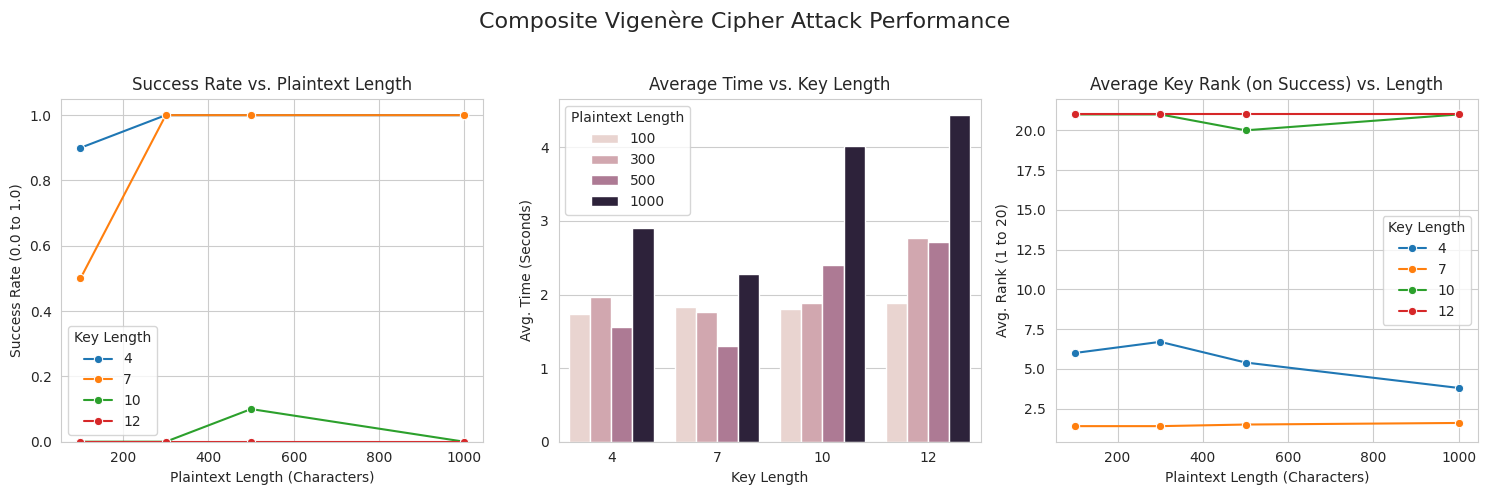

In [ ]:
# --------------------------------------------------------------------------------------
# 1. SETUP AND UTILITY FUNCTIONS (all cipher and attack functions)
# --------------------------------------------------------------------------------------

from collections import Counter, defaultdict
import math
import itertools
import re
import random
import time
import string
import statistics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import heapq

# --- Original Utility Functions (MUST be included) ---
ALPH = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
A2I = {c: i for i, c in enumerate(ALPH)}  # A->0
I2A = {i: c for i, c in enumerate(ALPH)}  # 0->A

ENGLISH_FREQ = {
    'A': 0.08167, 'B': 0.01492, 'C': 0.02782, 'D': 0.04253, 'E': 0.12702, 'F': 0.02228,
    'G': 0.02015, 'H': 0.06094, 'I': 0.06966, 'J': 0.00153, 'K': 0.00772, 'L': 0.04025,
    'M': 0.02406, 'N': 0.06749, 'O': 0.07507, 'P': 0.01929, 'Q': 0.00095, 'R': 0.05987,
    'S': 0.06327, 'T': 0.09056, 'U': 0.02758, 'V': 0.00978, 'W': 0.02360, 'X': 0.00150,
    'Y': 0.01974, 'Z': 0.00074
}

COMMON_WORDS = ["THE","AND","TO","OF","IN","IS","YOU","THAT","IT","HE","WAS","FOR","ON","ARE","AS","WITH","HIS","THEY","I"]

def normalize(text):
    return "".join(ch for ch in text.upper() if ch.isalpha())

def caesar_shift_text(text, shift):
    return "".join(I2A[(A2I[ch] + shift) % 26] for ch in text)

def vigenere_encrypt(text, key):
    out = []
    for i, ch in enumerate(text):
        k = key[i % len(key)]
        out.append(I2A[(A2I[ch] + k) % 26])
    return "".join(out)

def vigenere_decrypt(text, key):
    out = []
    for i, ch in enumerate(text):
        k = key[i % len(key)]
        out.append(I2A[(A2I[ch] - k) % 26])
    return "".join(out)

def composite_encrypt(plaintext, key_letters):
    text = normalize(plaintext)
    key = key_letters
    for kr in key:
        text = caesar_shift_text(text, kr)
        text = vigenere_encrypt(text, key)
    return text

def composite_decrypt(ciphertext, key_letters):
    text = normalize(ciphertext)
    key = key_letters
    for kr in reversed(key):
        text = vigenere_decrypt(text, key)
        text = caesar_shift_text(text, -kr)
    return text

def find_repeats(ciphertext, min_len=3, max_len=5):
    s = normalize(ciphertext)
    repeats = defaultdict(list)
    for L in range(min_len, max_len+1):
        seen = {}
        for i in range(len(s)-L+1):
            sub = s[i:i+L]
            if sub in seen:
                repeats[sub].append(i - seen[sub])
            else:
                seen[sub] = i
    distances = []
    for sub, dists in repeats.items():
        for d in dists:
            if d > 0:
                distances.append(d)
    return distances

def factor_counts(n):
    facs = set()
    for f in range(2, 51):
        if n % f == 0:
            facs.add(f)
    return facs

def kasiski_candidates(ciphertext):
    distances = find_repeats(ciphertext)
    fact_count = Counter()
    for d in distances:
        for f in factor_counts(d):
            fact_count[f] += 1
    if not fact_count:
        return []
    return [cand for cand, _ in fact_count.most_common(10)]

def index_of_coincidence(text):
    s = normalize(text)
    n = len(s)
    if n <= 1:
        return 0.0
    freq = Counter(s)
    ic = sum(v*(v-1) for v in freq.values()) / (n*(n-1))
    return ic

def ioc_for_period(ciphertext, period):
    s = normalize(ciphertext)
    cols = [''.join(s[i::period]) for i in range(period)]
    ics = [index_of_coincidence(c) for c in cols if c]
    return sum(ics)/len(ics) if ics else 0.0

def ioc_candidates(ciphertext, max_period=20):
    scores = []
    for p in range(1, max_period+1):
        scores.append((p, ioc_for_period(ciphertext, p)))
    scores.sort(key=lambda x: x[1], reverse=True)
    return scores[:8]

def chi_squared_stat(observed_counts, expected_freq, total):
    chi = 0.0
    for ch in ALPH:
        expected = expected_freq.get(ch, 0) * total
        observed = observed_counts.get(ch, 0)
        if expected > 0:
            chi += (observed - expected)**2 / expected
    return chi

def best_shift_for_column(column):
    n = len(column)
    if n == 0:
        return 0, 0.0
    counts = Counter(column)
    best = None
    for s in range(26):
        shifted_counts = Counter()
        for ch, cnt in counts.items():
            shifted_ch = I2A[(A2I[ch] - s) % 26]
            shifted_counts[shifted_ch] += cnt
        chi = chi_squared_stat(shifted_counts, ENGLISH_FREQ, n)
        if best is None or chi < best[0]:
            best = (chi, s)
    return best[1], best[0]

def egcd(a, b):
    if a == 0:
        return (b, 0, 1)
    else:
        g, y, x = egcd(b % a, a)
        return (g, x - (b // a) * y, y)

def inv_mod(a, m):
    g, x, _ = egcd(a % m, m)
    if g != 1:
        return None
    else:
        return x % m

def solve_for_S_total(sum_K, m):
    coef = (2*m) % 26
    g = math.gcd(coef, 26)
    solutions = []
    if sum_K % g != 0:
        return []
    coef_r = coef // g
    mod_r = 26 // g
    rhs_r = (sum_K // g) % mod_r
    inv = inv_mod(coef_r, mod_r)
    if inv is None:
        for cand in range(26):
            if (coef * cand - sum_K) % 26 == 0:
                solutions.append(cand % 26)
    else:
        s0 = (rhs_r * inv) % mod_r
        for k in range(g):
            solutions.append((s0 + k*mod_r) % 26)
    return sorted(set(solutions))

def solve_for_k_t(K_eff_t, S_total, m):
    rhs = (K_eff_t - S_total) % 26
    g = math.gcd(m, 26)
    sols = []
    if rhs % g != 0:
        return []
    m_r = m // g
    mod_r = 26 // g
    rhs_r = (rhs // g) % mod_r
    inv = inv_mod(m_r, mod_r)
    if inv is None:
        for cand in range(26):
            if (m * cand - K_eff_t + S_total) % 26 == 0:
                sols.append(cand % 26)
    else:
        k0 = (rhs_r * inv) % mod_r
        for t in range(g):
            sols.append((k0 + t*mod_r) % 26)
    return sorted(set(sols))

def recover_effective_key(ciphertext, m):
    s = normalize(ciphertext)
    K_eff = []
    chi_vals = []
    for t in range(m):
        col = s[t::m]
        shift, chi = best_shift_for_column(col)
        K_eff.append(shift % 26)
        chi_vals.append(chi)
    return K_eff, chi_vals

def score_plaintext(pt):
    s = pt.upper()
    word_hits = sum(s.count(w) for w in COMMON_WORDS)
    counts = Counter(s.replace(" ", ""))
    chi = chi_squared_stat(counts, ENGLISH_FREQ, max(1, len(s.replace(" ", ""))))
    return word_hits * 50 - chi

def beam_search_keys_from_Keff(K_eff, m, beam_width=200, top_shifts_per_col=3,
                               max_combos_per_period=20000, time_limit_sec=10):
    start_time = time.time()
    sumK = sum(K_eff) % 26
    S_total_candidates = solve_for_S_total(sumK, m)
    if not S_total_candidates:
        S_total_candidates = list(range(26))
    combos_yielded = 0

    for S_total in S_total_candidates:
        per_col_solutions = []
        for t in range(m):
            sols = solve_for_k_t(K_eff[t], S_total, m)
            if not sols:
                sols = list(range(26))
            if len(sols) > top_shifts_per_col:
                sols = sols[:top_shifts_per_col]
            per_col_solutions.append(sols)

        beam = [()]
        total_considered = 0
        for t in range(m):
            next_beam = []
            for partial in beam:
                for candidate in per_col_solutions[t]:
                    new_partial = partial + (candidate,)
                    next_beam.append(new_partial)
                    total_considered += 1
                    if total_considered >= max_combos_per_period: break
                if total_considered >= max_combos_per_period: break

            if len(next_beam) > beam_width:
                next_beam = next_beam[:beam_width]
            beam = next_beam
            if time.time() - start_time > time_limit_sec: break

        for full_key in beam:
            if len(full_key) == m:
                combos_yielded += 1
                yield (S_total, full_key)
                if combos_yielded >= max_combos_per_period: return
            if time.time() - start_time > time_limit_sec: return

def attack_memory_safe(ciphertext, max_period=12, top_periods=5,
                       top_shifts_per_col=3, beam_width_per_period=300,
                       max_results=10, max_combos_per_period=20000, time_limit_sec=12):
    ctext = normalize(ciphertext)
    kas = kasiski_candidates(ctext)
    ioc_cands = ioc_candidates(ctext, max_period=max_period)
    ioc_sorted = [p for p,_ in ioc_cands]
    period_candidates = []
    for cand in (kas + ioc_sorted):
        if cand not in period_candidates and 1 <= cand <= max_period:
            period_candidates.append(cand)
    if not period_candidates:
        period_candidates = list(range(1, max_period+1))
    period_candidates = period_candidates[:top_periods]

    heap = []
    total_checked = 0
    start = time.time()

    for m in period_candidates:
        if time.time() - start > time_limit_sec: break
        K_eff, chis = recover_effective_key(ctext, m)

        gen = beam_search_keys_from_Keff(K_eff, m, beam_width=beam_width_per_period,
                                         top_shifts_per_col=top_shifts_per_col,
                                         max_combos_per_period=max_combos_per_period,
                                         time_limit_sec=max(1, time_limit_sec//len(period_candidates)))
        for S_total, key_tuple in gen:
            key_list = list(key_tuple)
            pt = composite_decrypt(ctext, key_list)
            sc = score_plaintext(pt)
            total_checked += 1

            if len(heap) < max_results:
                heapq.heappush(heap, (sc, m, K_eff, S_total, key_list, pt))
            else:
                if sc > heap[0][0]:
                    heapq.heapreplace(heap, (sc, m, K_eff, S_total, key_list, pt))

            if time.time() - start > time_limit_sec: break
        if time.time() - start > time_limit_sec: break

    best = sorted(heap, key=lambda x: x[0], reverse=True)
    results = []
    for sc, m, K_eff, S_total, key_list, pt in best:
        results.append({
            'score': sc, 'period': m, 'K_eff': K_eff, 'S_total': S_total,
            'key': key_list, 'plaintext': pt
        })
    return results, period_candidates, ioc_cands, total_checked

# --------------------------------------------------------------------------------------
# 2. EXPERIMENT LOGIC
# --------------------------------------------------------------------------------------

def generate_random_plaintext(length):
    # Generates somewhat 'English-like' text
    words = []
    current_len = 0
    while current_len < length:
        word = random.choice(COMMON_WORDS)
        if current_len + len(word) > length:
             words.append(random.choice(string.ascii_uppercase) * (length - current_len))
             current_len = length
        else:
             words.append(word)
             current_len += len(word)

    pt_normalized = "".join(words)[:length]

    # Re-introduce spaces randomly for scoring to be effective
    pt_formatted = ""
    for char in pt_normalized:
        pt_formatted += char
        if random.random() < 0.25 and pt_formatted[-1] != ' ':
            pt_formatted += " "

    return pt_formatted.strip()

def generate_random_key(length):
    return [random.randint(0, 25) for _ in range(length)]

def check_key_match(found_key, target_key):
    return found_key == target_key

def readable_key(key_list):
    return ''.join(I2A[k] for k in key_list)

def run_trial(plaintext_len, key_len, trial_id, **attack_params):
    """Runs one full attack trial and returns metrics."""
    # 1. Setup
    original_key_letters = generate_random_key(key_len)
    plaintext_formatted = generate_random_plaintext(plaintext_len)

    ct = composite_encrypt(plaintext_formatted, original_key_letters)

    # 2. Attack
    start_time = time.time()
    results, period_cands, _, total_checked = attack_memory_safe(
        ciphertext=ct, max_period=key_len + 5, **attack_params
    )
    end_time = time.time()
    duration = end_time - start_time

    # 3. Analyze
    is_period_candidate = key_len in period_cands
    key_rank = -1

    for rank, r in enumerate(results, 1):
        if check_key_match(r['key'], original_key_letters):
            key_rank = rank
            break

    return {
        'trial_id': trial_id,
        'Plaintext_Length': plaintext_len,
        'Key_Length': key_len,
        'Is_Key_Found': key_rank > 0,
        'Key_Rank': key_rank if key_rank > 0 else len(results) + 1,
        'Time_sec': duration,
        'Candidates_Checked': total_checked,
        'Is_Period_Candidate': is_period_candidate,
        'Original_Key': readable_key(original_key_letters),
        'Top_Score': results[0]['score'] if results else -1e9,
    }

def run_experiment(lengths, key_lens, trials_per_config=5, **attack_params):
    """Automates trials across various parameters."""
    print(f"Starting experiment with {len(lengths) * len(key_lens) * trials_per_config} total trials...")
    all_results = []
    trial_counter = 0

    for length in lengths:
        for key_len in key_lens:
            print(f"\n--- Config: Length={length}, Key_Len={key_len} ({trials_per_config} trials) ---")

            for i in range(trials_per_config):
                trial_counter += 1
                try:
                    trial_result = run_trial(length, key_len, trial_counter, **attack_params)
                    all_results.append(trial_result)
                    print(f"  Trial {i+1}/{trials_per_config} complete: Found={trial_result['Is_Key_Found']} (Rank={trial_result['Key_Rank']}, Time={trial_result['Time_sec']:.2f}s)")
                except Exception as e:
                    print(f"  Trial {i+1}/{trials_per_config} FAILED: {e}")
                    # Log failure gracefully
                    all_results.append({
                        'trial_id': trial_counter, 'Plaintext_Length': length, 'Key_Length': key_len,
                        'Is_Key_Found': False, 'Key_Rank': -2, 'Time_sec': 0,
                        'Candidates_Checked': 0, 'Is_Period_Candidate': False,
                        'Original_Key': 'ERROR', 'Top_Score': -1e9
                    })

    print("\nExperiment complete.")
    return pd.DataFrame(all_results)

# --------------------------------------------------------------------------------------
# 3. RUN EXPERIMENT AND VISUALIZATION
# --------------------------------------------------------------------------------------

# --- Configuration ---
TEST_PLAINTEXT_LENGTHS = [100, 300, 500, 1000]
TEST_KEY_LENGTHS = [4, 7, 10, 12]
TRIALS_PER_CONFIGURATION = 10 # Set to a higher number (e.g., 10 or 20) for statistical significance

ATTACK_PARAMS = {
    'top_periods': 6,
    'top_shifts_per_col': 3,
    'beam_width_per_period': 300,
    'max_results': 20,
    'max_combos_per_period': 5000,
    'time_limit_sec': 15
}

# --- Execution ---
print("🚀 Starting Cipher Attack Performance Evaluation...")
results_df = run_experiment(
    TEST_PLAINTEXT_LENGTHS,
    TEST_KEY_LENGTHS,
    TRIALS_PER_CONFIGURATION,
    **ATTACK_PARAMS
)

print("\n" + "="*80)
print("--- RAW RESULTS DATAFRAME (First 5 Rows) ---")
print(results_df.head())

# --- Aggregation for Visualization ---

# Convert boolean to numeric for plotting success rate
results_df['Is_Key_Found_Numeric'] = results_df['Is_Key_Found'].astype(int)

# Group and calculate metrics
summary_df = results_df.groupby(['Plaintext_Length', 'Key_Length']).agg(
    Success_Rate=('Is_Key_Found_Numeric', 'mean'),
    Avg_Time_sec=('Time_sec', 'mean'),
    Avg_Checked=('Candidates_Checked', 'mean'),
    Avg_Rank_Success=('Key_Rank', lambda x: x[results_df.loc[x.index, 'Is_Key_Found']].mean())
).reset_index()

# Handle cases where no success occurred (Avg_Rank_Success might be NaN)
summary_df['Avg_Rank_Success'] = summary_df['Avg_Rank_Success'].fillna(ATTACK_PARAMS['max_results'] + 1)

print("\n" + "="*80)
print("--- SUMMARY DATAFRAME ---")
print(summary_df)

# --- Save to Colab Environment (CSV) ---
CSV_FILENAME = "composite_vigenere_attack_summary.csv"
summary_df.to_csv(CSV_FILENAME, index=False)
print(f"\n✅ Results saved to {CSV_FILENAME} in your Colab environment.")


# --------------------------------------------------------------------------------------
# 4. VISUALIZATION
# --------------------------------------------------------------------------------------

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 5)
plt.suptitle('Composite Vigenère Cipher Attack Performance', fontsize=16)

# Convert Key_Length to string for categorical plotting
summary_df['Key_Length_Str'] = summary_df['Key_Length'].astype(str)

### Plot 1: Success Rate vs. Plaintext Length
plt.subplot(1, 3, 1)
sns.lineplot(data=summary_df, x='Plaintext_Length', y='Success_Rate', hue='Key_Length_Str', marker='o')
plt.title('Success Rate vs. Plaintext Length', fontsize=12)
plt.xlabel('Plaintext Length (Characters)')
plt.ylabel('Success Rate (0.0 to 1.0)')
plt.legend(title='Key Length')
plt.ylim(0, 1.05)

### Plot 2: Average Time vs. Key Length
plt.subplot(1, 3, 2)
sns.barplot(data=summary_df, x='Key_Length_Str', y='Avg_Time_sec', hue='Plaintext_Length')
plt.title('Average Time vs. Key Length', fontsize=12)
plt.xlabel('Key Length')
plt.ylabel('Avg. Time (Seconds)')
plt.legend(title='Plaintext Length')

### Plot 3: Average Key Rank vs. Plaintext Length
plt.subplot(1, 3, 3)
sns.lineplot(data=summary_df, x='Plaintext_Length', y='Avg_Rank_Success', hue='Key_Length_Str', marker='o')
plt.title('Average Key Rank (on Success) vs. Length', fontsize=12)
plt.xlabel('Plaintext Length (Characters)')
plt.ylabel(f'Avg. Rank (1 to {ATTACK_PARAMS["max_results"]})')
plt.legend(title='Key Length')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# --------------------------------------------------------------------------------------
# END OF CODE
# --------------------------------------------------------------------------------------